<a href="https://colab.research.google.com/github/Tanay-8358/Mini-Project/blob/main/Resnet_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# --- Imports & Data Setup ---
import os, glob, zipfile
from google.colab import drive
import shutil
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Mount Drive and unzip dataset
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Tanay Salve/Main_project_06022025/data/archive (1).zip'
temp_path = '/content/dataset_temp'
if not os.path.exists(temp_path):
    with zipfile.ZipFile(zip_path, 'r') as z: z.extractall(temp_path)

dataset_dir = temp_path  # contains 'train' and 'test' subfolders


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Dataset Definition ---
class DeepFakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.paths, self.labels = [], []
        for label, sub in enumerate(['FAKE','REAL']):
            for p in glob.glob(os.path.join(root_dir, sub, '*.jpg')):
                self.paths.append(p); self.labels.append(label)
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, self.labels[idx]

# Transforms and DataLoaders template
def get_loaders(bs):
    tf = transforms.Compose([
        transforms.Resize((224,224)), transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
    tr = DeepFakeDataset(os.path.join(dataset_dir,'train'), tf)
    te = DeepFakeDataset(os.path.join(dataset_dir,'test'), tf)
    return DataLoader(tr, batch_size=bs, shuffle=True), DataLoader(te, batch_size=bs)

# --- Model Definition ---
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__(); m=models.resnet18(pretrained=True)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        self.model=m
    def forward(self,x): return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:

# --- Training & Validation with History ---
def train_validate(model, tr_loader, val_loader, criterion, opt, epochs):
    history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
    all_probs, all_targets = [], []
    for e in range(epochs):
        # Train
        model.train(); rl, rc, rt=0,0,0
        for x,y in tr_loader:
            x,y=x.to(device),y.to(device); opt.zero_grad()
            o=model(x); loss=criterion(o,y); loss.backward(); opt.step()
            rl+=loss.item(); preds=o.argmax(1)
            rc+=(preds==y).sum().item(); rt+=y.size(0)
        history['train_loss'].append(rl/len(tr_loader))
        history['train_acc'].append(rc/rt*100)
        # Validate
        model.eval(); vl, vc, vt=0,0,0
        with torch.no_grad():
            for x,y in val_loader:
                x,y=x.to(device),y.to(device)
                o=model(x); vl+=criterion(o,y).item()
                probs=torch.softmax(o,1).cpu().numpy(); all_probs.append(probs)
                all_targets.append(y.cpu().numpy())
                preds=o.argmax(1); vc+=(preds==y).sum().item(); vt+=y.size(0)
        history['val_loss'].append(vl/len(val_loader))
        history['val_acc'].append(vc/vt*100)
        print(f"Epoch {e+1}/{epochs} | TL {history['train_loss'][-1]:.4f}, TA {history['train_acc'][-1]:.1f}% | \
              VL {history['val_loss'][-1]:.4f}, VA {history['val_acc'][-1]:.1f}%")
    return np.vstack(all_probs), np.concatenate(all_targets), history

# --- Plotting Functions ---
def plot_history(h):
    ep=range(1,len(h['train_loss'])+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(ep,h['train_loss'],label='Train'); plt.plot(ep,h['val_loss'],label='Val')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1,2,2); plt.plot(ep,h['train_acc'],label='Train'); plt.plot(ep,h['val_acc'],label='Val')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('%'); plt.legend(); plt.show()

def evaluate_report(t, p, names=['FAKE','REAL']):
    preds=p.argmax(1)
    print(classification_report(t,preds,target_names=names))
    cm=confusion_matrix(t,preds)
    sns.heatmap(cm,annot=True,fmt='d',xticklabels=names,yticklabels=names)
    plt.title('Confusion Matrix'); plt.ylabel('True'); plt.xlabel('Pred'); plt.show()

def plot_roc(t, p):
    n= p.shape[1]
    t_one=np.eye(n)[t]
    for i in range(n):
        f,tpr,_=roc_curve(t_one[:,i],p[:,i]); auc_score=auc(f,tpr)
        plt.plot(f,tpr,label=f"Class {i} AUC={auc_score:.2f}")
    f_m,t_m,_=roc_curve(t_one.ravel(),p.ravel()); plt.plot(f_m,t_m,'--',label=f"Macro AUC={auc(t_m,f_m):.2f}")
    plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(); plt.show()

def plot_distribution(ds, title):
    labs=[l for _,l in ds]
    sns.countplot(x=["FAKE" if l==0 else "REAL" for l in labs])
    plt.title(title); plt.show()



-- LR=0.0005, BS=32, OPT=SGD --


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 | TL 0.1673, TA 93.3% |               VL 0.0916, VA 96.5%
Epoch 2/5 | TL 0.0963, TA 96.4% |               VL 0.0740, VA 97.2%
Epoch 3/5 | TL 0.0712, TA 97.3% |               VL 0.0703, VA 97.3%
Epoch 4/5 | TL 0.0521, TA 98.0% |               VL 0.0671, VA 97.5%
Epoch 5/5 | TL 0.0392, TA 98.5% |               VL 0.0664, VA 97.6%
Final Test Acc: 97.21%


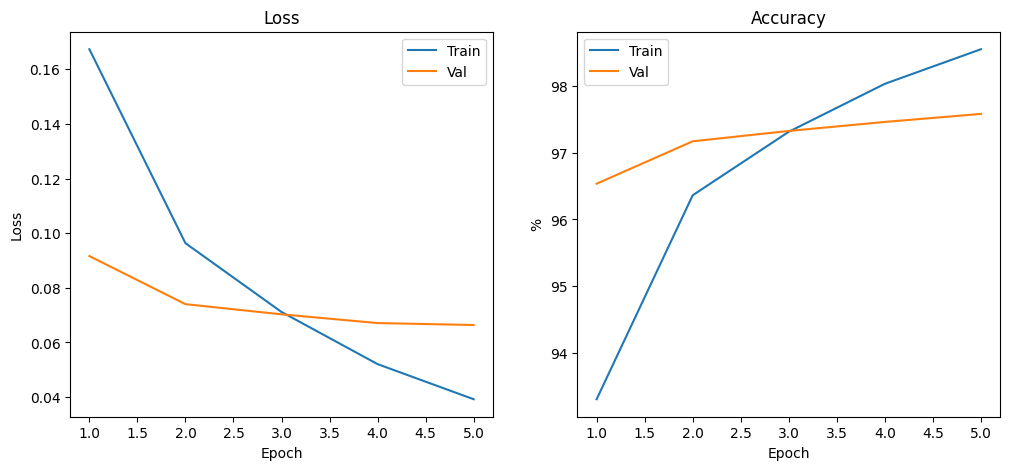

              precision    recall  f1-score   support

        FAKE       0.97      0.97      0.97     50000
        REAL       0.97      0.97      0.97     50000

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000



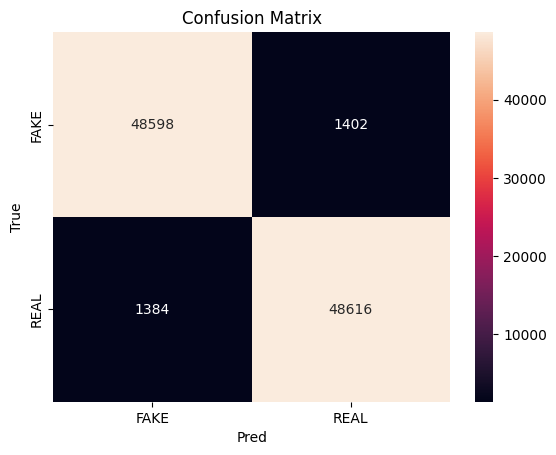

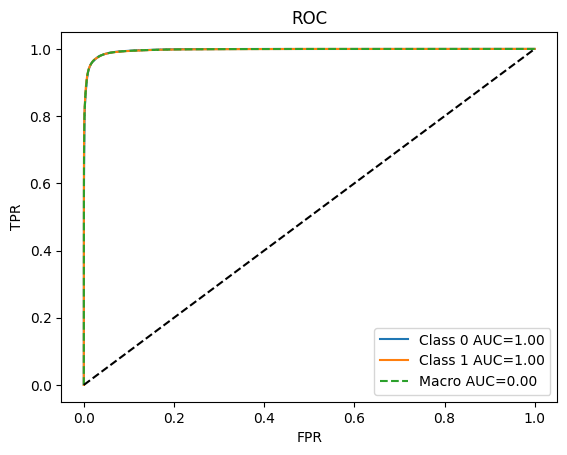

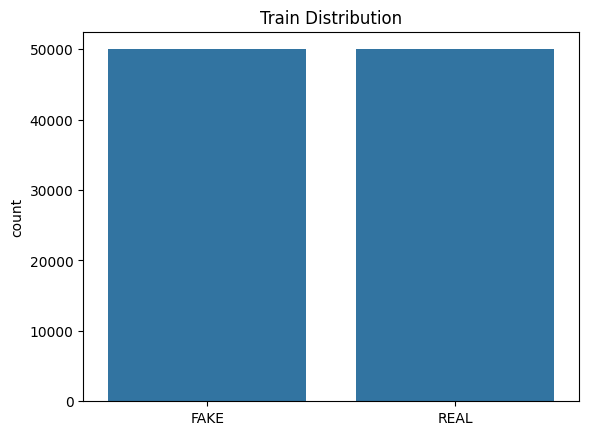

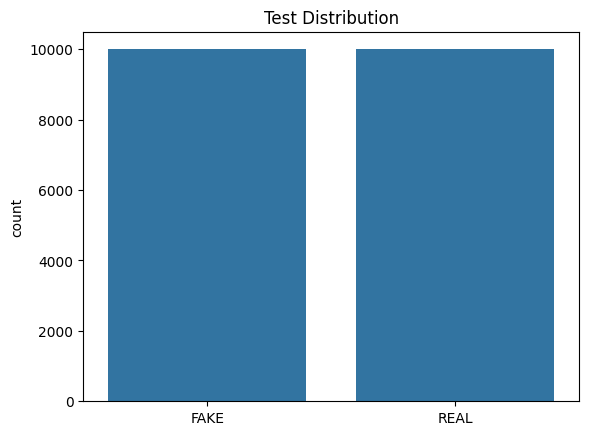

In [ ]:
# --- Hyperparameter Search & Visualization ---
params = {'lr':[0.0005], 'bs':[32], 'opt':['sgd']}
results=[]
for lr in params['lr']:
    for bs in params['bs']:
        for optn in params['opt']:
            print(f"\n-- LR={lr}, BS={bs}, OPT={optn.upper()} --")
            trl, tel = get_loaders(bs)
            mdl=ResNet18().to(device)
            crit=nn.CrossEntropyLoss()
            opt = torch.optim.SGD(mdl.parameters(), lr=lr, momentum=0.9) if optn=='sgd' else torch.optim.Adam(mdl.parameters(), lr=lr)
            probs, targets, hist = train_validate(mdl, trl, tel, crit, opt, epochs=5)
            acc = (probs.argmax(1)==targets).mean()*100
            print(f"Final Test Acc: {acc:.2f}%")
            results.append({'lr':lr,'bs':bs,'opt':optn,'acc':acc})
            # Visualize for this config
            plot_history(hist)
            evaluate_report(targets, probs)
            plot_roc(targets, probs)
            # EDA
            plot_distribution(trl.dataset, 'Train Distribution')
            plot_distribution(tel.dataset, 'Test Distribution')

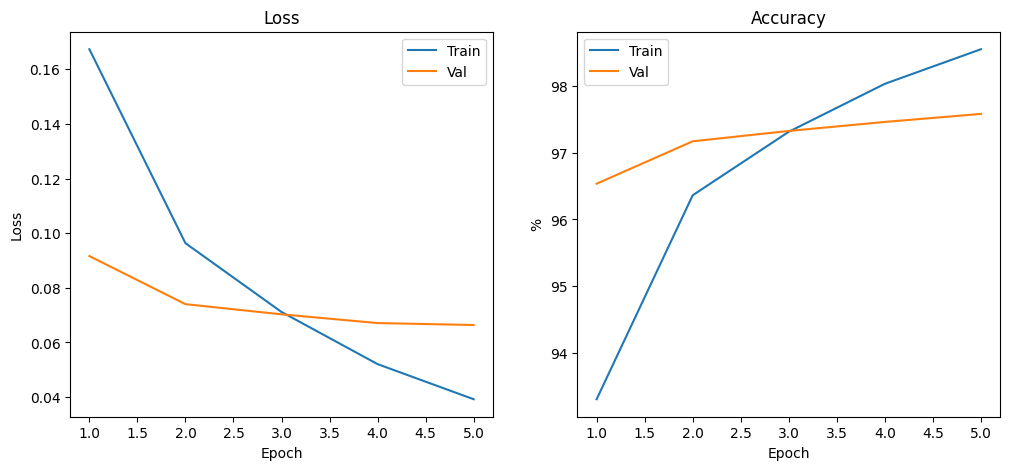

In [ ]:
#Loss, Accracy graph
plot_history(hist)

              precision    recall  f1-score   support

        FAKE       0.97      0.97      0.97     50000
        REAL       0.97      0.97      0.97     50000

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000



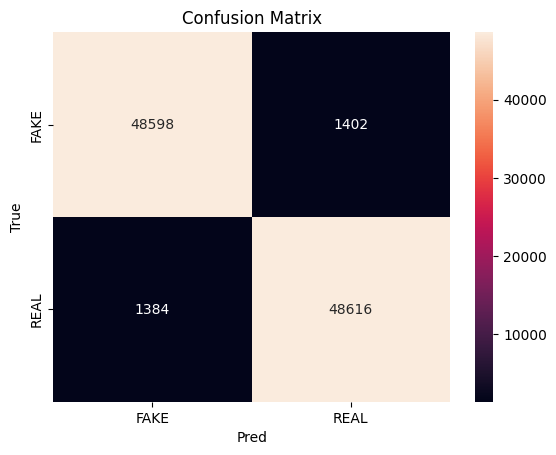

In [ ]:
#Clssification report & Confusion matrix
evaluate_report(targets, probs)

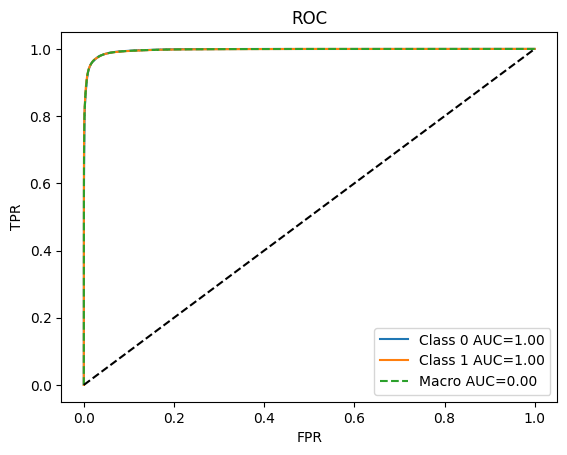

In [ ]:
#AUC-ROC Curve
plot_roc(targets, probs)